In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
DATA_DIR = 'data/'

all_xray_df = pd.read_csv(f'{DATA_DIR}Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(30)


Scans found: 0 , Total Headers 112120


Image Index                             Finding Labels  \
79162   00019434_000.png                                 No Finding   
29456   00007670_016.png                                 No Finding   
53869   00013594_050.png                     Consolidation|Effusion   
68594   00016934_045.png                                 No Finding   
21400   00005710_000.png                                 No Finding   
8030    00002108_000.png                                 No Finding   
82927   00020393_007.png                        Infiltration|Nodule   
112025  00030740_000.png                                 No Finding   
87554   00021625_000.png                                 No Finding   
1105    00000272_002.png                                 No Finding   
51019   00012892_006.png                           Emphysema|Nodule   
2017    00000514_006.png                                 No Finding   
1493    00000391_000.png                                 No Finding   
35410   00009343_003.png                                 No Finding   
48553   00012305_000.png                                 No Finding   
101980  00027132_000.png                                 No Finding   
102926  00027440_000.png                                       Mass   
35798   00009432_005.png                   Atelectasis|Infiltration   
66422   00016422_005.png            Effusion|Emphysema|Pneumothorax   
104143  00027810_000.png                                 No Finding   
45074   00011576_004.png                                 No Finding   
107077  00028883_000.png                                 No Finding   
88655   00021969_001.png  Cardiomegaly|Effusion|Infiltration|Nodule   
11648   00003046_004.png         Effusion|Hernia|Pleural_Thickening   
70912   00017500_002.png                       Atelectasis|Effusion   
26854   00007018_028.png                                 No Finding   
44279   00011391_057.png                                 No Finding   
23651   00006262_000.png                                 No Finding   
111122  00030323_049.png                                 No Finding   
101533  00026971_026.png                               Infiltration   

        Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
79162             0       19434           62              F            AP   
29456            16        7670           45              F            PA   
53869            50       13594           47              M            AP   
68594            45       16934           57              M            AP   
21400             0        5710           22              F            PA   
8030              0        2108           59              M            PA   
82927             7       20393           43              M            AP   
112025            0       30740           23              M            AP   
87554             0       21625           46              F            PA   
1105              2         272           30              F            PA   
51019             6       12892           42              M            PA   
2017              6         514           58              F            PA   
1493              0         391           85              F            PA   
35410             3        9343           22              M            AP   
48553             0       12305           29              M            PA   
101980            0       27132           69              M            PA   
102926            0       27440           43              M            PA   
35798             5        9432           71              M            PA   
66422             5       16422           36              F            PA   
104143            0       27810           31              M            PA   
45074             4       11576           70              M            PA   
107077            0       28883           19              M            PA   
88655             1       21969         

## EDA

### 1. Diseases distribution

Find the proportion of the images with pneumonia/without pneumonia.

In [3]:
all_xray_df = all_xray_df.rename(columns = {'Image Index' : 'image_index', 'Finding Labels': 'finding_labels',
                             'Follow-up #':'follow_up', 'Patient ID': 'patient_id', 'Patient Age':'patient_age',
                             'Patient Gender':'patient_gender', 'View Position':'view_position', 
                              'OriginalImage[Width':'orig_img_width', 'Height]':'orig_img_height',
                             'OriginalImagePixelSpacing[x':'pixel_spacing', 'Unnamed: 11':'unnamed_11'})

In [4]:
all_xray_df.loc[all_xray_df['finding_labels'].str.contains('Pneumonia')].shape[0]

1431

In [5]:
all_xray_df[all_xray_df['finding_labels'].str.contains('Pneumonia')].shape[0]/all_xray_df.shape[0]

0.012763110952550838

Only 1% of the total images have diagnosed pneumonia.
That means that we'll need to discard most of the images while training

Now, show the distribution of all 14 diseases 

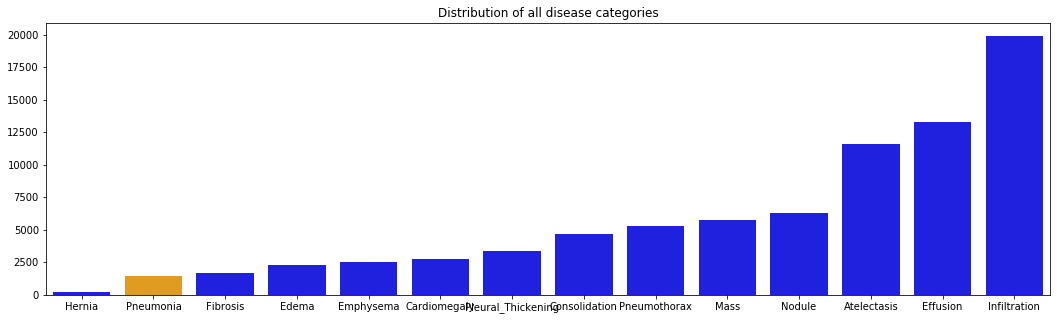

In [6]:
diseases = np.array(['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 
            'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'])
diseases_counts = []

for disease in diseases:
    diseases_counts.append(all_xray_df[all_xray_df['finding_labels'].str.contains(disease)].shape[0])
diseases_counts = np.array(diseases_counts)
diseases = diseases[diseases_counts.argsort()]
diseases_counts.sort()

pal = ['blue' if x != 'Pneumonia' else 'orange' for x in diseases]

plt.figure(figsize=(18,5))
plt.title('Distribution of all disease categories')# (any type of disease presence)')
sns.barplot(diseases, diseases_counts, palette=pal);

Now, let's check the distribution for primary deseases

In [7]:
new = all_xray_df["finding_labels"].str.split('|', n=1, expand=True)
all_xray_df['disease'] = new[0]
all_xray_df['comorbidity'] = new[1]

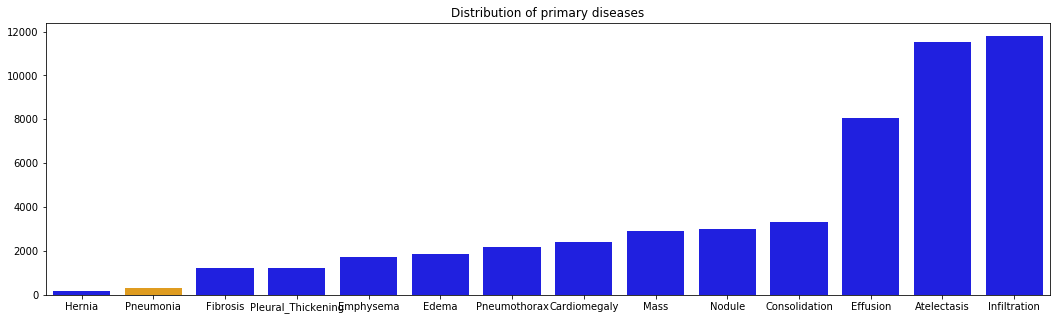

In [8]:
diseases = np.array(['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 
            'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'])
diseases_counts = []

for disease in diseases:
    diseases_counts.append(all_xray_df[all_xray_df['disease'].str.contains(disease)].shape[0])
diseases_counts = np.array(diseases_counts)
diseases = diseases[diseases_counts.argsort()]
diseases_counts.sort()

pal = ['blue' if x != 'Pneumonia' else 'orange' for x in diseases]

plt.figure(figsize=(18,5))
plt.title('Distribution of primary diseases')
sns.barplot(diseases, diseases_counts, palette=pal);

In [9]:
all_xray_df.comorbidity.fillna(value='No Finding', inplace=True)

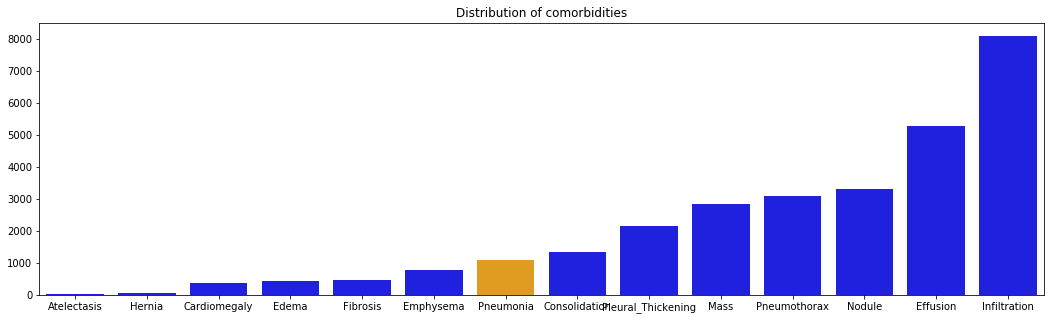

In [10]:
diseases = np.array(['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 
            'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'])
diseases_counts = []

for disease in diseases:
    diseases_counts.append(all_xray_df[all_xray_df['comorbidity'].str.contains(disease)].shape[0])
diseases_counts = np.array(diseases_counts)
diseases = diseases[diseases_counts.argsort()]
diseases_counts.sort()

pal = ['blue' if x != 'Pneumonia' else 'orange' for x in diseases]

plt.figure(figsize=(18,5))
plt.title('Distribution of comorbidities')
sns.barplot(diseases, diseases_counts, palette=pal);

As we can see from this plot, Pneumonia is mostly a comorbidity. So it will be important to check if there is a pneumonia as a comorbidity before discarding a sample while pre-processing the dataset for training.

### 2. Demographics

#### Age distribution

In [11]:
all_xray_df.patient_age.max()

414

In [12]:
all_xray_df.loc[all_xray_df['patient_age'] > 120, 'patient_age'] = all_xray_df[all_xray_df['patient_age'] > 120]['patient_age'].map(lambda x: x/10).max()

In [13]:
all_xray_df.patient_age.max()

95.0

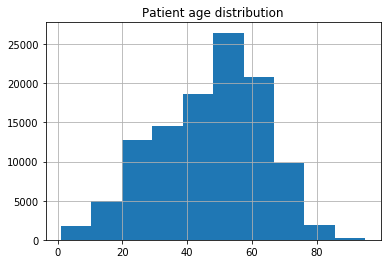

In [14]:
ax = all_xray_df.patient_age.hist()
ax.set_title('Patient age distribution');

Here we can see a normal distribution, it's already fine for further data processing 

#### Gender distribution

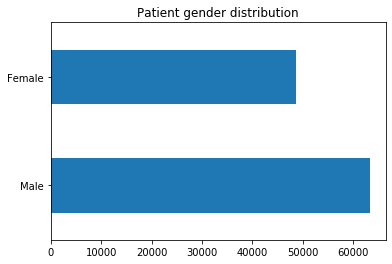

In [15]:
ax = all_xray_df.patient_gender.value_counts().plot(kind='barh')
ax.set_yticklabels(['Male', 'Female'])
ax.set_title('Patient gender distribution');

From this bar chart we can see that the difference in gender distribution is not crucial, but there are more x-rays taken from men. It will probably worth adding a bit of zooming in the data augmentation process.

### 3. Image visualizations.

Get full image paths first

In [16]:
data_image_paths = {os.path.basename(x): x for x in glob(os.path.join(DATA_DIR, 'images*', 'images', '*png'))}
all_xray_df['image_path'] = all_xray_df['image_index'].map(data_image_paths.get)
del all_xray_df['image_index']

Now plot 5 samples for every disease in the dataset 

In [17]:
# extend the labels to include no findings
all_labels = diseases.copy()
all_labels = np.append(all_labels, 'No Finding')

In [33]:
# plot 5 samples for each class
def plot_samples(column, label):
    samples = all_xray_df[all_xray_df[column] == label].sample(5)
    fig, ax = plt.subplots(1, 5, figsize=(20,4))
    ax = ax.flatten()
    fig.suptitle(label, fontsize = 20)
    for image_path, axi in zip(samples.image_path.values, ax):
        axi.set_xticks([])
        axi.set_yticks([])
        axi.imshow(plt.imread(image_path), cmap='gray')

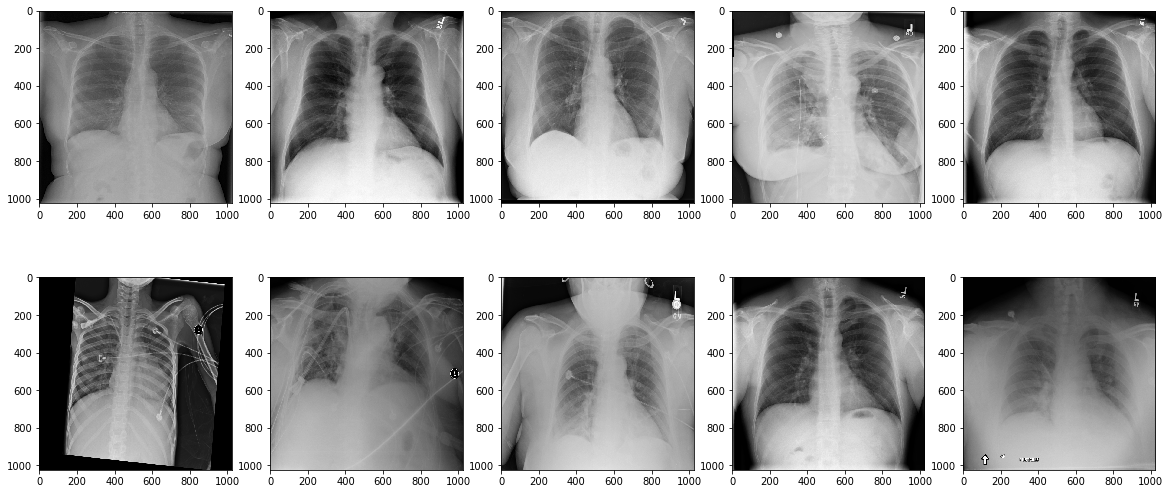

In [56]:
spl = all_xray_df.sample(10)
fig, ax = plt.subplots(2, 5, figsize=(20,9))
ax = ax.flatten()
for image_path, axi in zip(spl.image_path.values, ax):
    axi.imshow(plt.imread(image_path), cmap='gray')

Some images have black background, so its useful to crop this background while preprocessing

In [101]:
img = spl.iloc[5]['image_path']
img = plt.imread(img)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
print(img.shape)
img[[1,2,3,4], 200:300,:].shape

(1024, 1024, 3)


(4, 100, 3)

In [167]:
import cv2
def crop_image(img,tol=0.1):
    # img is 2D image data
    # tol  is tolerance
    
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

img_path = spl.iloc[4]['image_path']
#print(img_path.replace('data', 'data_new'))
img = cv2.imread(img_path)
cv2.imsave(img_path, img, cmap='gray')
print(img.shape)
img = crop_image(img, tol=0.1)
plt.imshow(img)
'''

fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].imshow(img, cmap='gray');
img = crop_image(img, tol=0.1)
ax[1].imshow(img, cmap='gray');
plt.imsave(img_path, img)


'''
print(img.shape)
cv2.imsave(img_path, img, cmap='gray')


AttributeError: module 'cv2' has no attribute 'imsave'

Looks better!

Now it would be great to crop this black background for all the images in the dataset and use this function for inference too.

In [144]:
from IPython.display import clear_output

siz = all_xray_df.shape[0]
i=0
for img_path in all_xray_df['image_path'].values:
    clear_output(wait=True)
    #img = plt.imread(img_path)
    #print(img.shape)
    #plt.figure()
    #plt.imshow(img)
    print('Progress: {0}/{1}'.format(i, siz))
    plt.imsave(img_path, crop_image(plt.imread(img_path)))
    i+=1

Progress: 0/112120


ValueError: Cross index must be 1 dimensional

In [145]:
img.shape

(1024, 1024, 4)

Plot 4 classes at once to make the output visible in the notebook

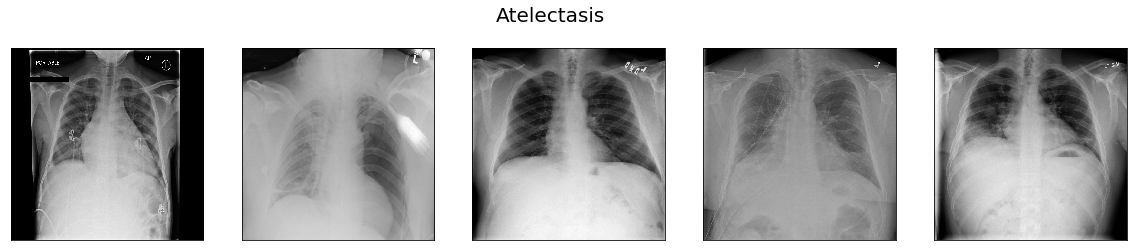

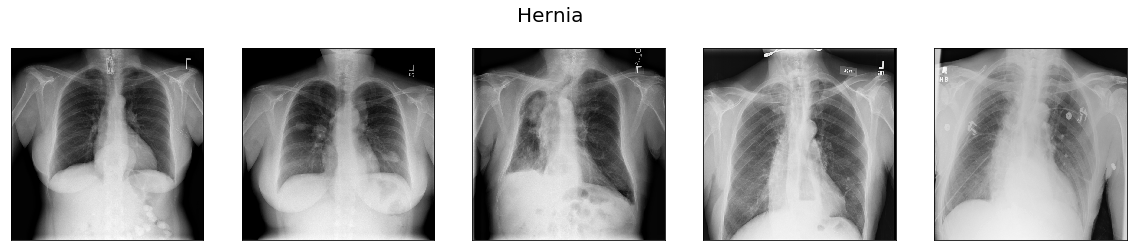

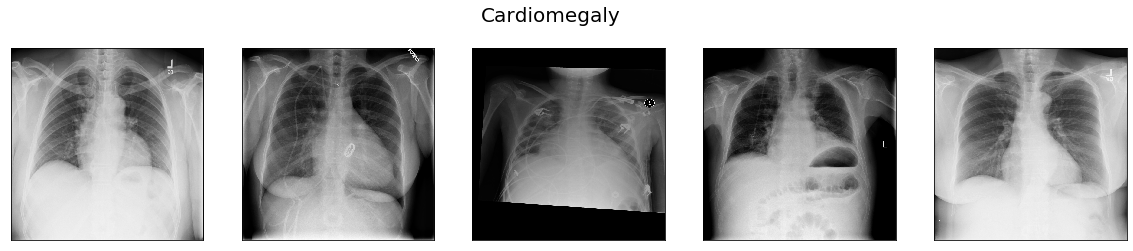

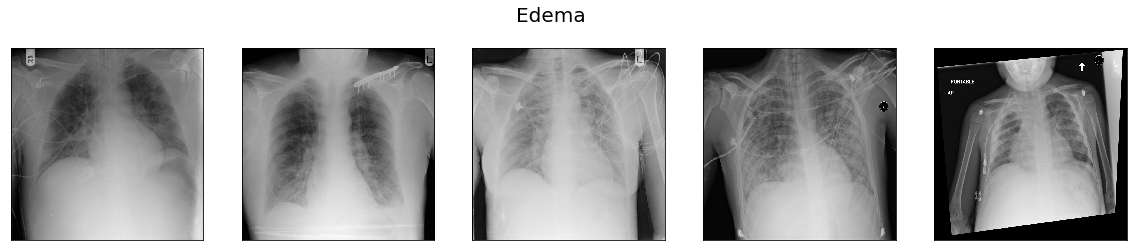

In [19]:
for label in all_labels[:4]:
    plot_samples('disease', label)

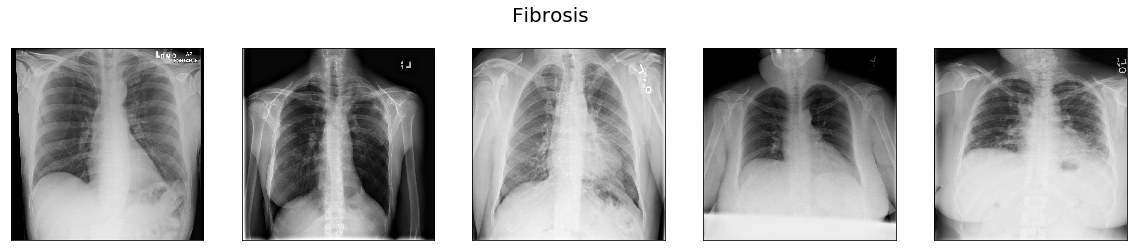

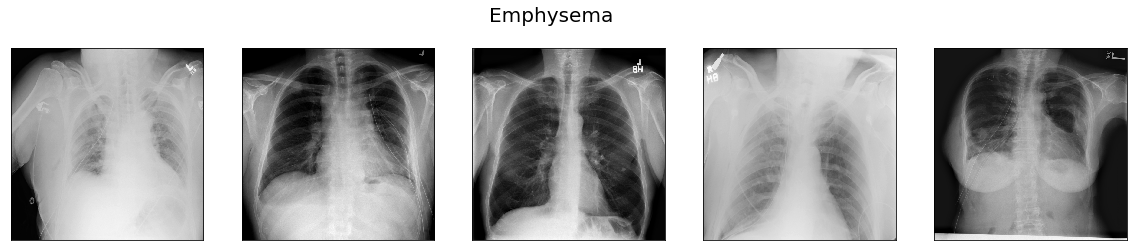

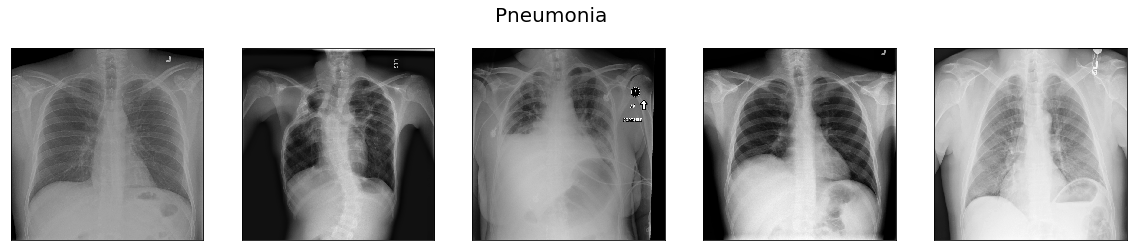

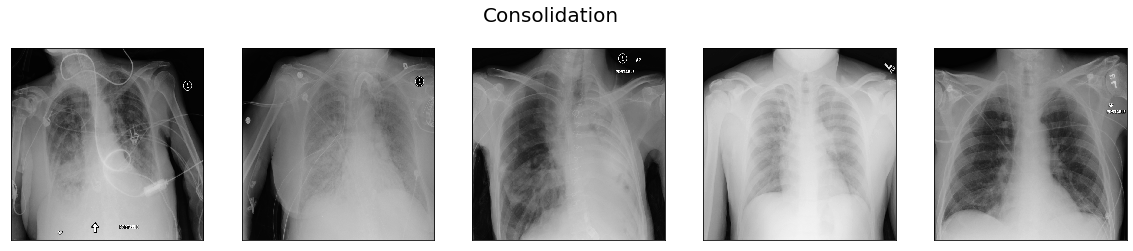

In [20]:
for label in all_labels[4:8]:
    plot_samples('disease', label)

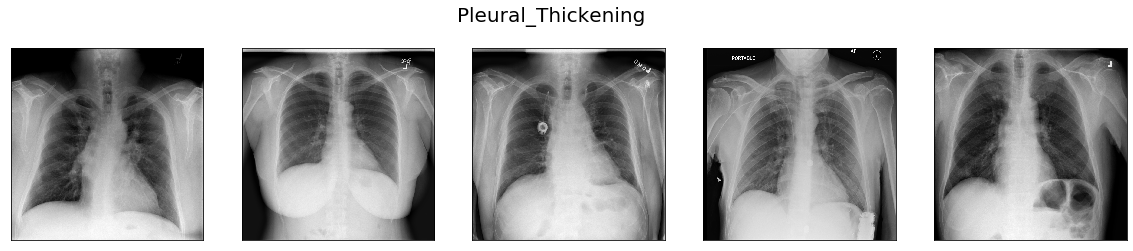

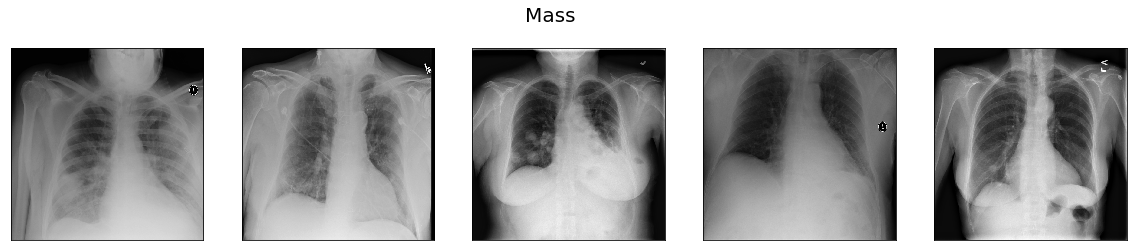

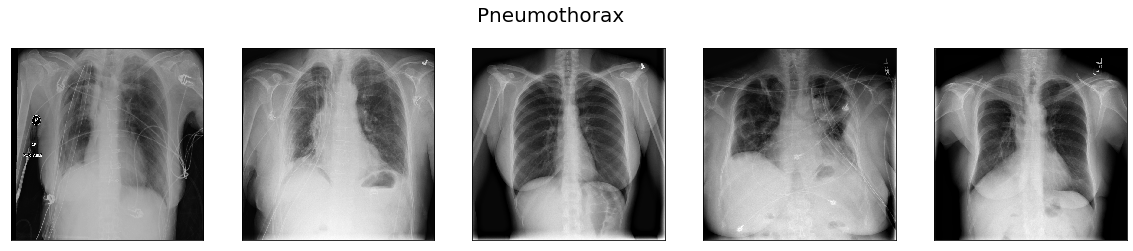

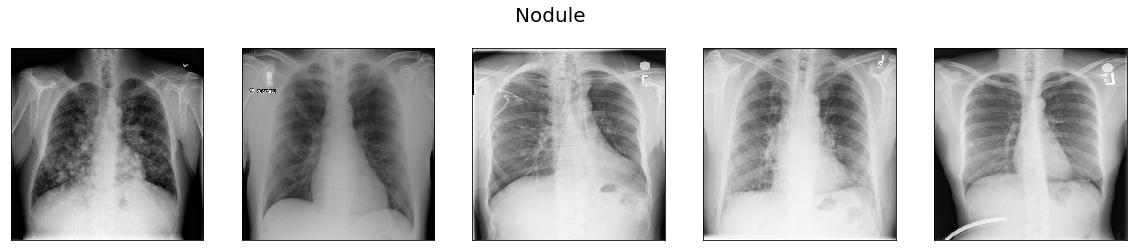

In [21]:
for label in all_labels[8:12]:
    plot_samples('disease', label)

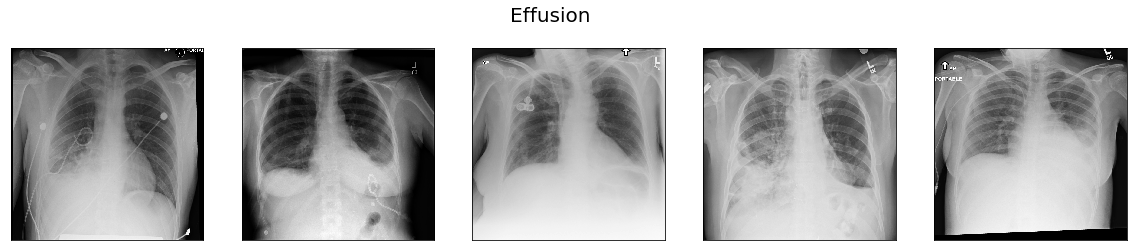

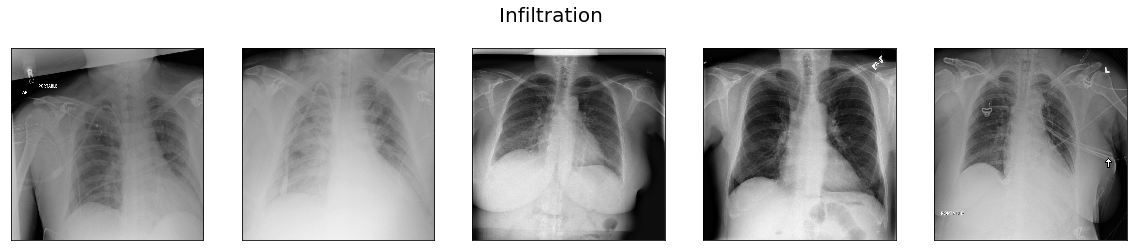

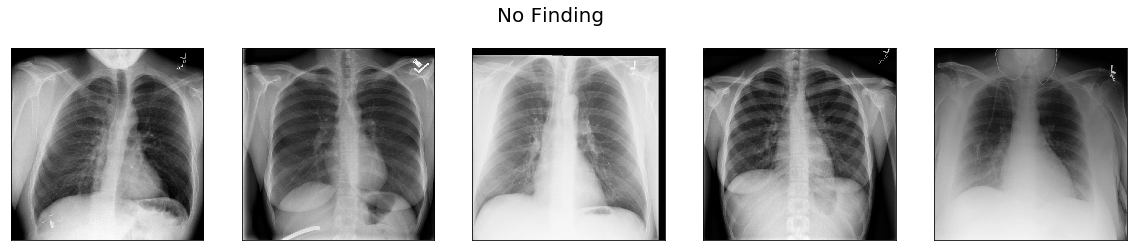

In [22]:
for label in all_labels[12:]:
    plot_samples('disease', label)

To be honest, I can't see too many differences between images with different findings. For example, Emphysema, Pneumonia and Consolidation look very similar for me (Now it makes sense why the radiologist job is hard and exhausting).
Probably, for the CNN it will be harder to correctly classify x-rays with pneumonia if there will be too many samples for Emphysema and Consolidation in the training set. So the training set should be as balanced as possible.

Now I want to explore the difference between view positions

In [23]:
all_xray_df.view_position.value_counts()

PA    67310
AP    44810
Name: view_position, dtype: int64

## Exploring different view positions:

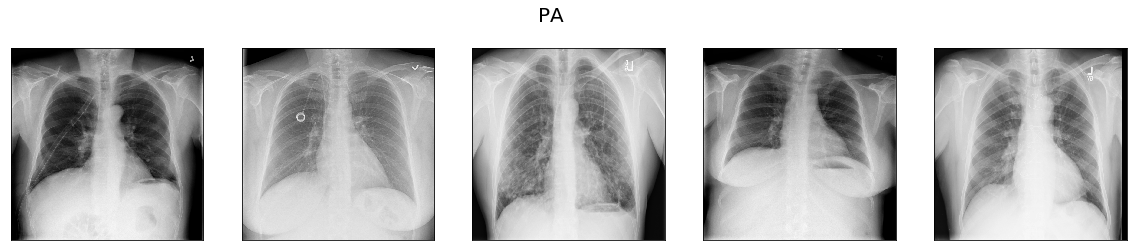

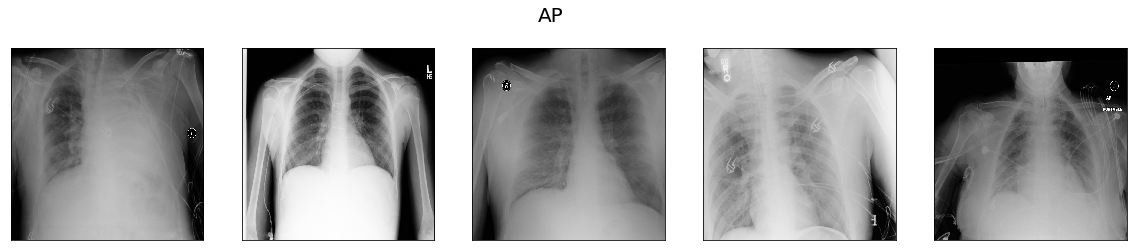

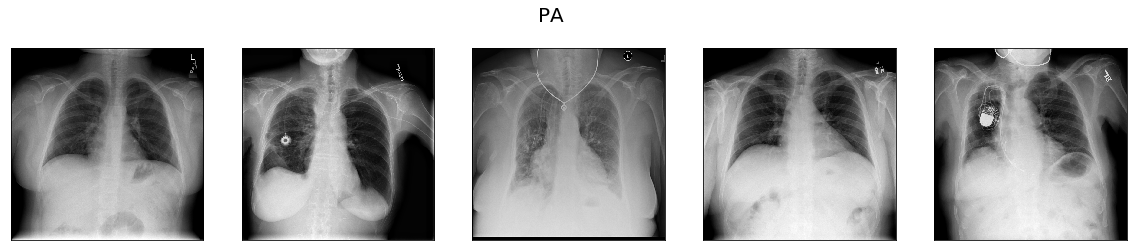

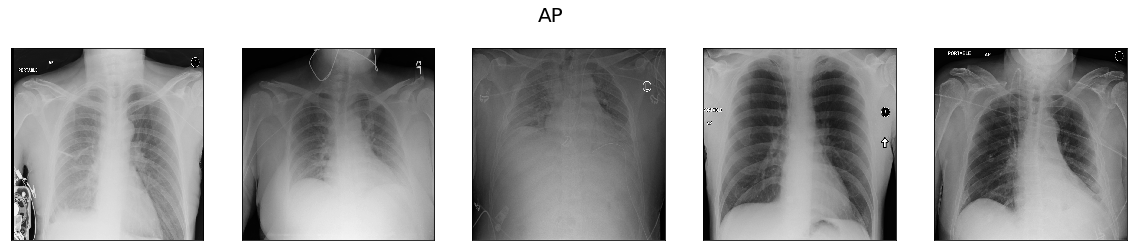

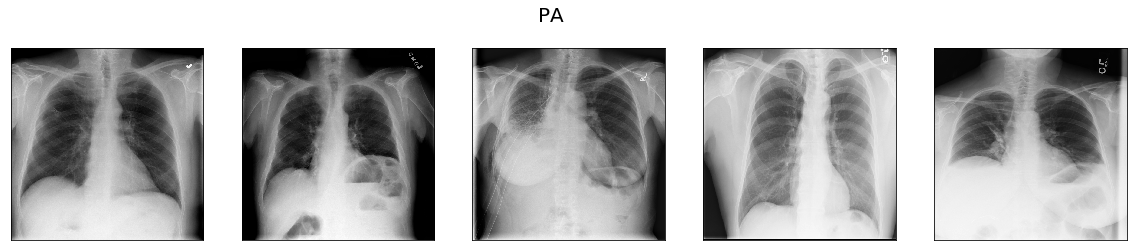

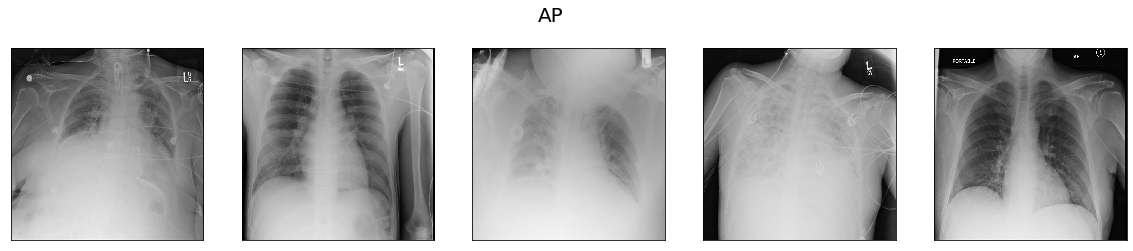

In [24]:
from IPython.display import Markdown, display
display(Markdown('## Exploring different view positions:'))
for i in range(3):
    plot_samples('view_position', 'PA')
    plot_samples('view_position', 'AP')

This parameter makes no difference for image classification.

However, I've noticed rotations on some of the x-rays. Need to add rotations in the augmentation process.

### 4. Intensity values of the pixel-level data

In [25]:
# read and preprocess data from sample_labels.csv
pl_df = pd.read_csv('sample_labels.csv')
pl_df = pl_df.rename(columns = {'Image Index' : 'image_index', 'Finding Labels': 'finding_labels',
                             'Follow-up #':'follow_up', 'Patient ID': 'patient_id', 'Patient Age':'patient_age',
                             'Patient Gender':'patient_gender', 'View Position':'view_position', 
                              'OriginalImage[Width':'orig_img_width', 'Height]':'orig_img_height',
                             'OriginalImagePixelSpacing[x':'pixel_spacing', 'Unnamed: 11':'unnamed_11'})
data_image_paths = {os.path.basename(x): x for x in glob(os.path.join(DATA_DIR, 'images*', 'images', '*png'))}
pl_df['image_path'] = pl_df['image_index'].map(data_image_paths.get)
del pl_df['image_index']
new = pl_df["finding_labels"].str.split('|', n=1, expand=True)
pl_df['disease'] = new[0]
pl_df['comorbidity'] = new[1]

In [26]:
def plot_intensities(label):
    samples = pl_df[pl_df['disease'] == label].sample(5)
    fig, ax = plt.subplots(1, 5, figsize=(20,4))
    ax = ax.flatten()
    fig.suptitle(label, fontsize = 20)
    for image_path, axi in zip(samples.image_path.values, ax):
        img = plt.imread(image_path)
        intensities = ((img - np.mean(img))/np.std(img)).ravel()
        #remove black border for better visibility
        intensities = intensities[intensities > 0.0001]
        axi.set_xticks([])
        axi.set_yticks([])
        axi.hist(intensities, bins=256)

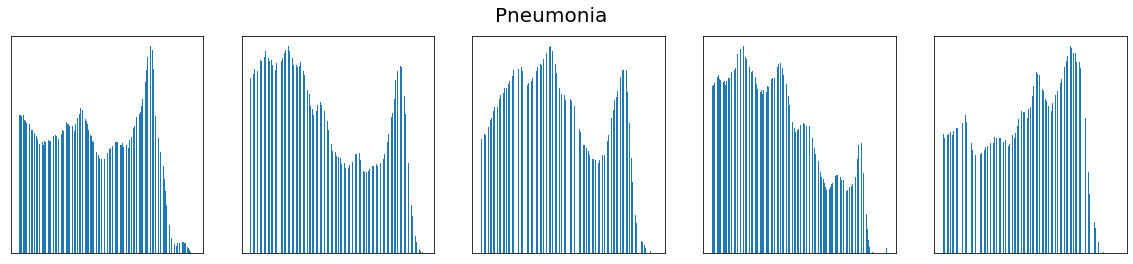

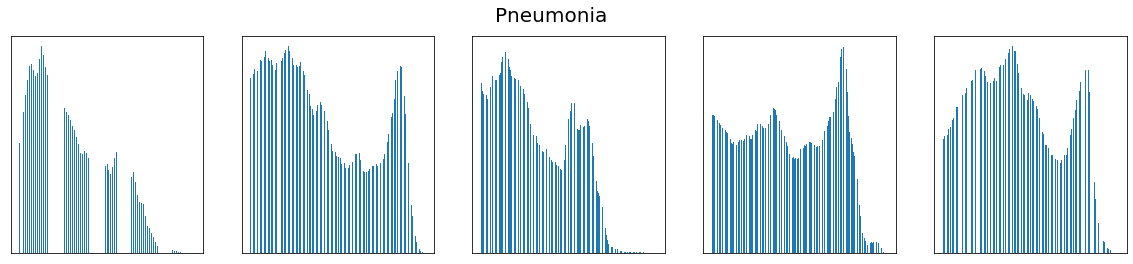

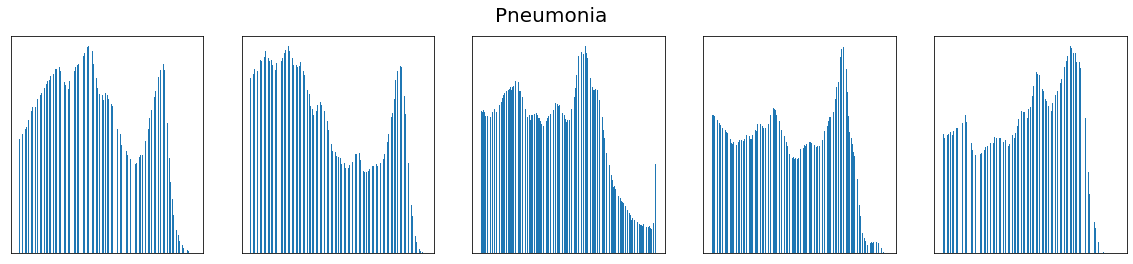

In [27]:
# plot some intensities for pneumonia
plot_intensities('Pneumonia')
plot_intensities('Pneumonia')
plot_intensities('Pneumonia')

Most of the histograms for pneumonia have two distinct peaks

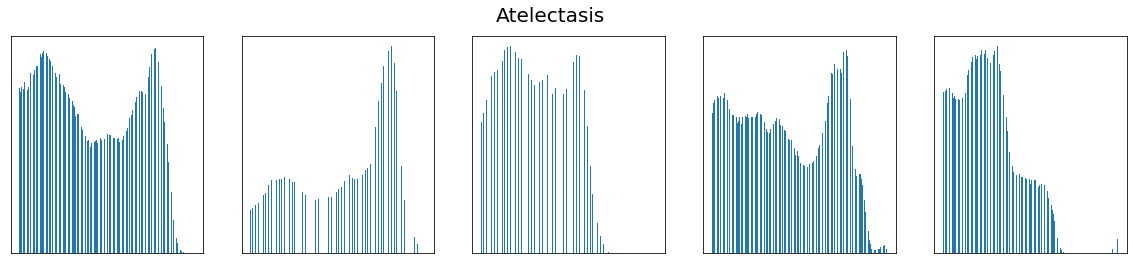

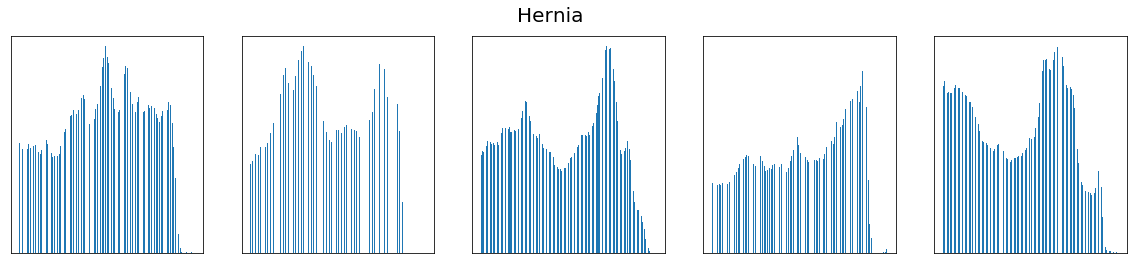

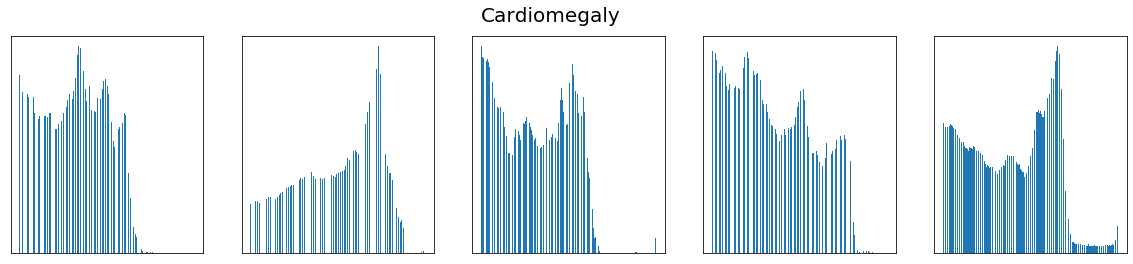

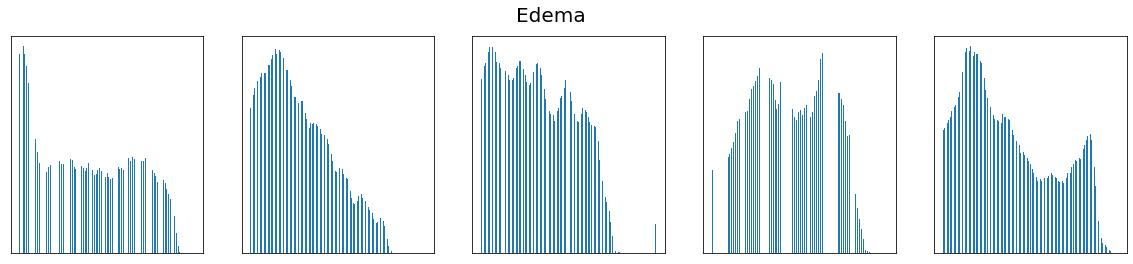

In [28]:
for label in all_labels[:4]:
    plot_intensities(label)

Here I can spot some differences as opposed to the raw image data. 

Cardiomegaly and atelectasis histograms mostly have only one peak.

Hernia histogram often has a peak on the right whilst Edema has a distinct peak on the left.

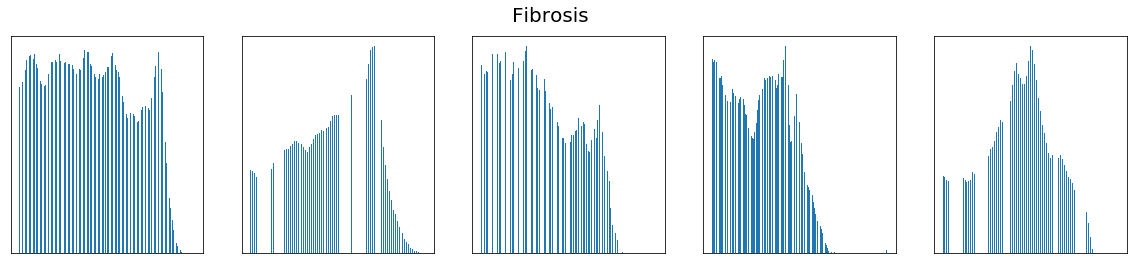

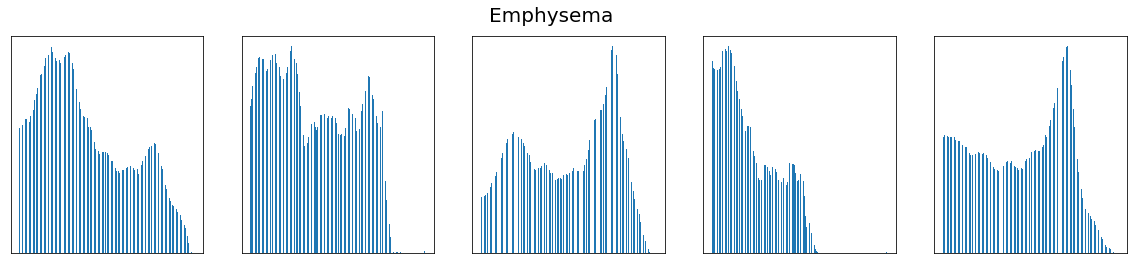

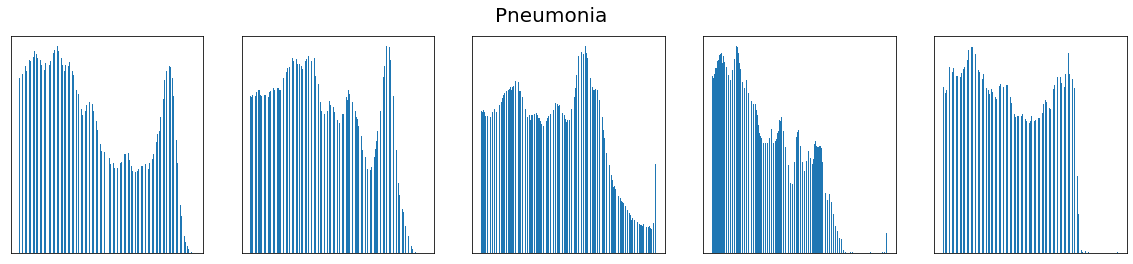

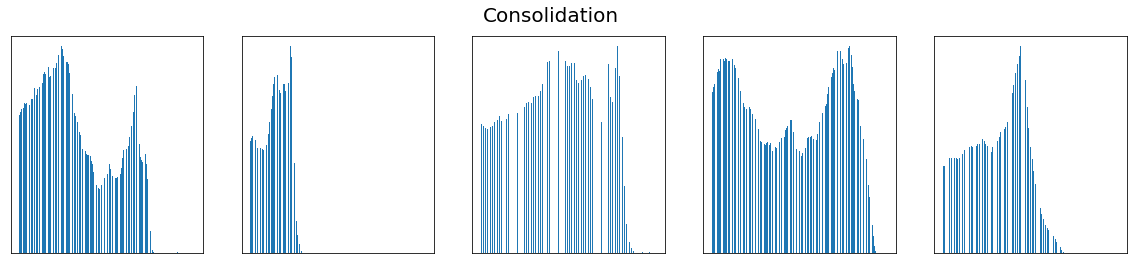

In [29]:
for label in all_labels[4:8]:
    plot_intensities(label)

Here we can spot 2-peaky Pneumonia without seeing its label.

Fibrosis histogram has one distinct peak on the left or on the right, and the histogram is skewed.

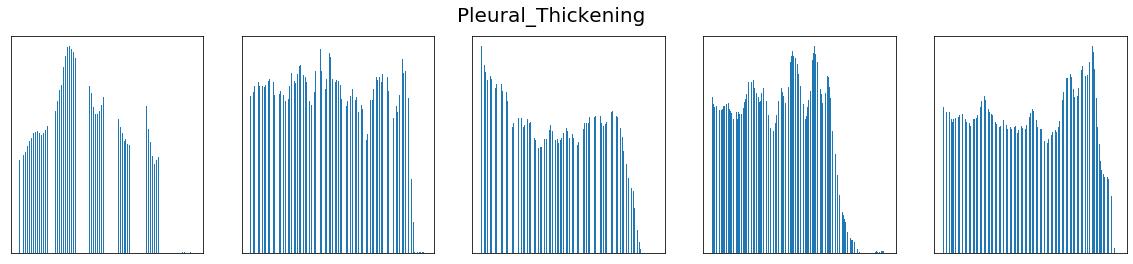

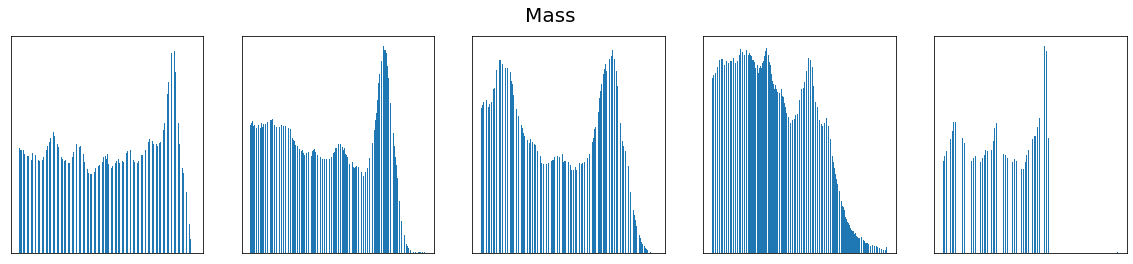

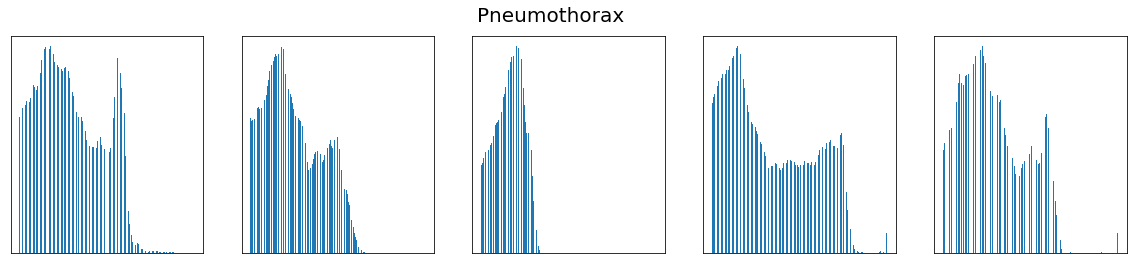

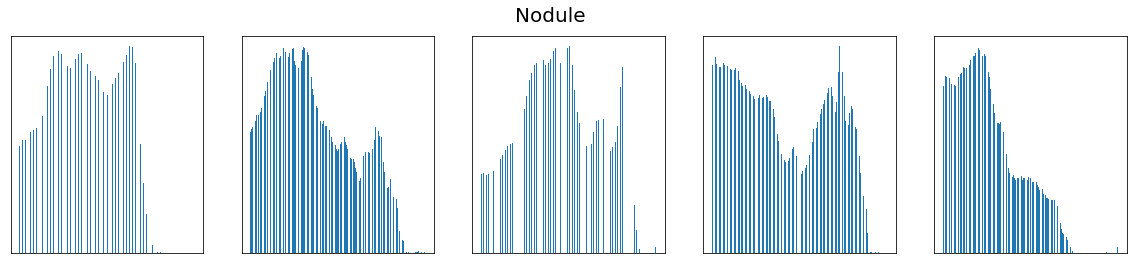

In [30]:
for label in all_labels[8:12]:
    plot_intensities(label)

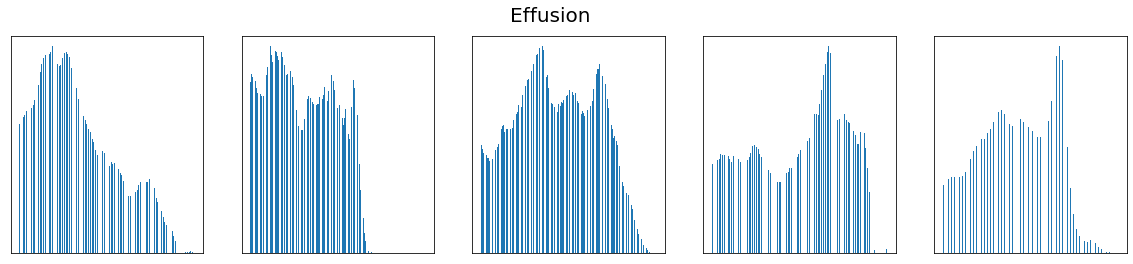

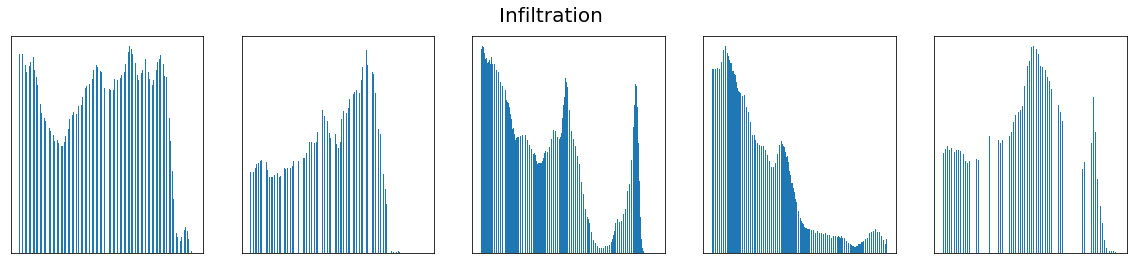

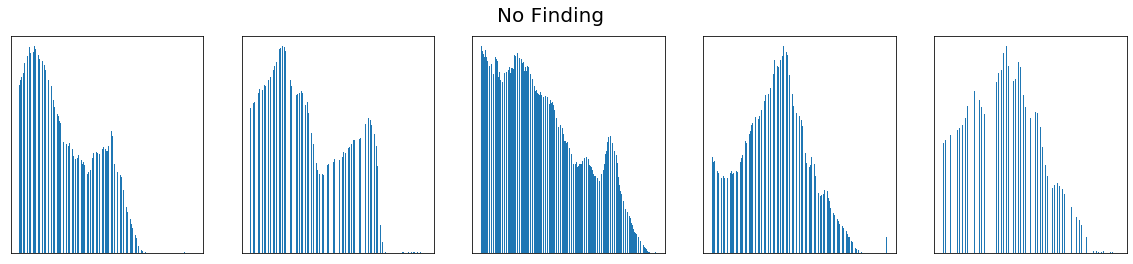

In [31]:
for label in all_labels[12:]:
    plot_intensities(label)

Unlike the raw image data, the intensity histograms may actually provide some insights about the disease type. Since CNN can extract and select more complex features that pixel intensity, I believe it can produce reliable results. 